In [ ]:
#Библиоткеки
!pip install xgboost

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (8, 6)


In [ ]:
#Загрузка датасета
df = pd.read_csv("parkinsons.data")
print(df.shape)
df.head()


(195, 24)


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [ ]:
#пропуски
df.info()
df.describe().T
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

,0
name,0
MDVP:Fo(Hz),0
MDVP:Fhi(Hz),0
MDVP:Flo(Hz),0
MDVP:Jitter(%),0
MDVP:Jitter(Abs),0
MDVP:RAP,0
MDVP:PPQ,0
Jitter:DDP,0
MDVP:Shimmer,0


In [ ]:
#Выбор признаков и целевой переменной
# целевая переменная
y = df['status']

# признаки: все, кроме 'status' и 'name'
X = df.drop(columns=['status', 'name'])

print("Форма X:", X.shape)
print("Форма y:", y.shape)


Форма X: (195, 22)
Форма y: (195,)


In [ ]:
#Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% на тест
    random_state=42,
    stratify=y            # сохраняем распределение классов
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 156
Test size: 39


In [ ]:
#Нормализация признаков
scaler = StandardScaler()

# Обучаем scaler по train и трансформируем train
X_train_scaled = scaler.fit_transform(X_train)

# Для test только трансформируем тем же scaler
X_test_scaled = scaler.transform(X_test)

print("Форма X_train_scaled:", X_train_scaled.shape)
print("Форма X_test_scaled:", X_test_scaled.shape)


Форма X_train_scaled: (156, 22)
Форма X_test_scaled: (39, 22)


In [ ]:
#Обучение модели
xgb_model = XGBClassifier(
    n_estimators=200,        # число деревьев
    learning_rate=0.05,      # шаг обучения
    max_depth=3,             # глубина деревьев
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',   # чтобы не ругался на метрику
    use_label_encoder=False
)

xgb_model.fit(X_train_scaled, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:49:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
#Accuracy + отчёт
y_pred = xgb_model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy на тестовой выборке: {acc*100:.2f}%")

print("\nClassification report:")
print(classification_report(y_test, y_pred))


Accuracy на тестовой выборке: 92.31%

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39



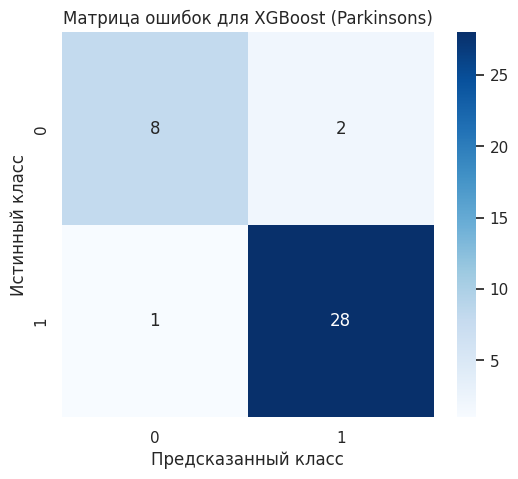

In [ ]:
#Матрица ошибок
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок для XGBoost (Parkinsons)')
plt.show()
